# 3K2F G-ADSA Analysis

In this document, we perform the gravimetry-axisymmetric drop shape analysis (G-ADSA) of a sample of polypropylene glycol (Sigma) with molecular weight ~2700 g/mol in an atmosphere of carbon dioxide. The experiment was performed in the lab of Prof. Ernesto Di Maio in the Department of Chemical Engineering, Materials, and Industrial Production (DICMaPI) at the University of Naples Federico II from June 17-21, 2019.

The analysis computes the **solubility, interfacial tension, diffusivity, and specific volume** of the sample at pressures from 0 to 55 bar at 31 C.

We begin by importing the required Python libraries and setting parameters for this particular analysis.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.optimize import curve_fit
import dataproc

from importlib import reload
reload(dataproc)

# SET PARAMETERS
# folder for ADSA data
adsa_folder = '../../EXPERIMENTS/Italy/data/adsa/'
# list of data files for ADSA generated from videos of a pendant drop
adsa_file_list = ['20190612_0614_1k2f_adsa_data.csv', '20190614_0617_1k2f_adsa_data.csv']
# file path for gravimetry data from the Rubotherm machine
grav_file_path = '../../EXPERIMENTS/Italy/data/gravimetry/v2110b-TRD-061219-1804.csv'
# file path to save results
save_file_path = '../../EXPERIMENTS/Italy/data/1k2f.csv'
# list of starting times of ADSA data relative to start of gravimetry data
# gravimetry 6/12 6:05:58pm; adsa video 1 6/12 6:16pm, adsa video2 6/14 7:02pm
adsa_t0_list = [3600*25 + 60*8 + 2, 24*3600*2 + 60*56 + 2]
# number of measurements to average for surface tension and volume readings
n_adsa = 3

# weight of sample in atmospheric pressure [g]
w_samp_atm = 0.686
# volume of drop in vacuum; if not available in video, input initial drop volume [uL]; o/w put 0
v_drop_0_manual = 3.332 
# density of polyol sample from Dow technical data sheet at atmospheric pressure and 25 C (TDS) [g/mL]
rho_samp_atm = 1.02 
# volume of hook and crucible as measured in helium [mL]
v_ref_he = 2.2675 # measured by Maria Rosaria Di Caprio @ 35 C [mL]
diam_cruc = 1.82 # diameter of crucible [cm]

# ordered list of pressure set points (within p_thresh_frac of true values) [kPa]
p_set_arr = np.array([0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500,
                       5000, 5500, 4650, 3900, 3150, 2400, 1650, 900, 700, 480, 
                       280, 230, 180, 130, 80])
p_thresh_frac = 0.04 # threshold for acceptable difference between actual pressure and set pressure [fraction]
dp_desorp = 700 # decrease in pressure during desorption [kPa]
di_desorp = 10 # duration of desorption step [# of measurements]

# CONSTANTS
# atmospheric pressure [kPa]
P_ATM = 101.3

## Load Data

Next we load the data from gravimetry and ADSA that we wish to process.

In [2]:
# initialize list to store interfacial tension measurements [mN/m]
if_tension = np.array([])
# also store drop volume measurements [uL]
drop_vol = np.array([])
# record time
t_adsa = np.array([])

# extract data from all data files for the pendant drop (ADSA)
for i in range(len(adsa_file_list)):
    adsa_file = adsa_file_list[i]
    df_adsa = pd.read_csv(adsa_folder + adsa_file, header=1)
    if_tension = np.concatenate((if_tension, df_adsa['IFT'].values))
    drop_vol = np.concatenate((drop_vol, df_adsa['PndVol'].values))
    t_adsa = np.concatenate((t_adsa, df_adsa['Secs.1'].values + adsa_t0_list[i]))

# load rubotherm data and process
df = pd.read_csv(grav_file_path, header=3)
# Extract time in terms of seconds after start
date_raw = df['DATE'].values
time_raw = df['TIME'].values
t_grav = dataproc.convert_time(date_raw, time_raw)
# shift time so initial time is zero to match interfacial tension time
t_grav -= t_grav[0]

# load rubotherm data in sync with time
br_arr = df['WEITGHT(g)'].values
bp_arr = df['BALANCE POSITION'].values
p_arr = df['Now Pressure(kPa)'].values

# initialize data frame to store data
df_meas = pd.DataFrame(columns=['p [kPa]', 'zero [g]', 'zero std [g]', 'mp1 [g]',
                        'mp1 std [g]', 'mp2 [g]', 'mp2 std [g]', 'if tension [mN/m]',
                        'if tension std [mN/m]', 'drop volume [uL]', 
                        'drop volume std [uL]'])
df_meas['p [kPa]'] = p_set_arr

## Synchronize Gravimetry and ADSA Measurements

In the next section, we synchronize gravimetry and ADSA measurements and identify their corresponding pressures. We then average the final values of the measurements of mass, tare, and interfacial tension (and take the standard deviation as an estimate of the error) and save them for further analysis.

In [3]:
# initalize marker for pressure bounds
last_bound = 0
# extract interfacial tension, drop volume, and mass at MP1 for each pressure
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    # get indices of each measurement with pressure within thresholds 
    i_p, last_bound = dataproc.get_inds_for_curr_p(p_arr, p_set, p_thresh_frac, last_bound)
    print(last_bound)
    # store results in data frame
    df_meas = dataproc.store_grav_adsa(df_meas, i, i_p, t_grav, t_adsa, br_arr, bp_arr, if_tension, drop_vol, n_adsa)

Pressure = 0 kPa.
1991
[1921 1922 1923]
[27.68831 27.68832 27.68832]
<function reject_outliers at 0x0000025CFD3B3158>


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Andy.DESKTOP-CFRG05F\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\g-adsa\dataproc.py:234: RuntimeWarning: invalid value encountered in less_equal
  i_adsa = np.where(t_adsa <= t_f)[0][-n_adsa:]
C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Anaconda3\lib\site-packages\nu

Interfacial tension = nan mN/m.
Drop volume = nan uL.
Pressure = 500 kPa.
3174
[549 550]
[27.62482 27.62483]
<function reject_outliers at 0x0000025CFD3B3158>
Interfacial tension = 22.836667 mN/m.
Drop volume = 3.345000 uL.
Pressure = 1000 kPa.
3707
[519 520 521]
[27.55897 27.55897 27.55897]
<function reject_outliers at 0x0000025CFD3B3158>
Interfacial tension = 21.990000 mN/m.
Drop volume = 3.358333 uL.
Pressure = 1500 kPa.
4209
[489 490 491]
[27.48945 27.48944 27.48944]
<function reject_outliers at 0x0000025CFD3B3158>
Interfacial tension = 20.763333 mN/m.
Drop volume = 3.417000 uL.
Pressure = 2000 kPa.
4723
[499 500 501]
[27.41594 27.41597 27.41598]
<function reject_outliers at 0x0000025CFD3B3158>
Interfacial tension = 19.783333 mN/m.
Drop volume = 3.470333 uL.
Pressure = 2500 kPa.
5257
[520 521]
[27.33789 27.33788]
<function reject_outliers at 0x0000025CFD3B3158>
Interfacial tension = 18.736667 mN/m.
Drop volume = 3.535667 uL.
Pressure = 3000 kPa.
5791
[520 521]
[27.2544  27.25443]
<f

## Analysis

Next we perform the analysis of the gravimetry and ADSA data to compute the solubility, diffusivity, and specific volume. We begin with the solubility.

### Interfacial Tension

The interfacial tension measurements are performed using pendant drop analysis with the software FTA32. These results do not require further analysis beyond the averaging and standard deviation performed above.

#### Ad Hoc Estimation of Polymer Mass and Volume under Vacuum

Before estimating the solubility, I must comptue the mass and volume of the polymer under vacuum. For this experiment, I lost the image of the drop under vacuum, so I must estimate the mass and volume of the polyol under vacuum by extrapolating from atmospheric measurements of mass and density. However, since I don't have Rubotherm measurements at atmospheric pressure, I extrapolated the mass between the masses at 80 kPa and 153 kPa. I then estimated the volume by assuming the same mass density as at atmo

In [4]:
# Because I am missing a measurement of the volume of the drop in vacuum, I must estimate
# the mass of the dry polymer in the following ad hoc manner:
# balance reading at each pressure at equilibrium (extract value at 0 pressure) [g]
br_eq = df_meas['mp1 [g]'].values - df_meas['zero [g]'].values
br_eq_0 = br_eq[0]
# balance reading for the mass of dissolved gas (must be corrected by buoyancy) [g]
br_gas = br_eq - br_eq_0
df_meas['dissolved gas balance reading [g]'] = br_gas
# sample volume at atmospheric pressure
v_samp_atm = w_samp_atm / rho_samp_atm
# buoyant force correction at 153 kPa (pressure step at index 2) [g]
buoyancy_153kPa = dataproc.rho_gas(p_set_arr[2])*(v_samp_atm + v_ref_he)
br_gas_153kPa = br_gas[2]
# weight of gas at 153 kPa (buoyancy-corrected) [g]
w_gas_153kPa = br_gas_153kPa + buoyancy_153kPa
# buoyant force correction at 80 kPa (pressure step at index -1) [g]
buoyancy_80kPa = dataproc.rho_gas(p_set_arr[-1])*(v_samp_atm + v_ref_he)
br_gas_80kPa = br_gas[-1]
# weight of gas at 80 kPa (buoyancy-corrected) [g]
w_gas_80kPa = br_gas_80kPa + buoyancy_80kPa
# approximate weight of gas at atmosphere with linear interpolation [g]
w_gas_atm = w_gas_80kPa + (w_gas_153kPa - w_gas_80kPa)*(P_ATM - 80)/(153 - 80)
# approximate mass of gas at atmospheric pressure as that at 153 kPa
w_poly = w_samp_atm - w_gas_atm
print('w_poly = %f g vs. w_samp_atm = %f g.' % (w_poly, w_samp_atm))
# calculate volume of dry (vacuum) sample using density at atmospheric pressure [mL]
v_poly = w_poly / rho_samp_atm

w_poly = 0.678999 g vs. w_samp_atm = 0.686000 g.


### Solubility

We perform the following calculations to estimate the solubility of CO2 in the polyol sample.

\begin{align*}
    BR_{eq}(p) &= BR_{mp1}(p) - BR_{zero}(p) \\
\end{align*}

where $BR_{eq}(p)$ is the equilibrium balance reading for the mass of the sample, dissolved gas, crucible, and hook at a pressure $p$; $BR_{mp1}$ is the balance reading at measuring point 1 (tare plus sample, dissolved gas, crucible, and hook); and $BR_{zero}$ is the tare value of the balance.

Then the balance reading for the mass of the gas is computed by subtracting the balance reading under vacuum (at which point we assume no gas in the sample),

\begin{align*}
    BR_{gas}(p) &= BR_{eq}(p) - BR_{eq}(p=0) \\
\end{align*}

where $BR_{gas}$ is the balance reading estimate for the mass of the gas, which requires correction by the buoyancy.

The buoyant force correction to mass is the density of the CO2 atmosphere times the volume of the weighed components,

\begin{align*}
    W_{buoy} &= \rho_{CO2}(p)(V_{samp}(p) + V_{ref}) \\
\end{align*}

where $W_{buoy}$ is the buoyant force correction to the weight, $rho_{CO2}(p)$ is the density of carbon dioxide at pressure $p$ (assuming a temperature of 30.5 C), $V_{samp}(p)$ is the volume of the sample at pressure $p$, and $V_{ref}$ is the volume of the crucible and hook, measured in a reference bath of helium at a temperature 35 C by Maria Rosaria Di Caprio to be 2.2675 mL.

Then the true weight of the gas dissolved in the polyol sample is 

\begin{align*}
    W_{gas} &= BR_{gas} + W_{buoy} \\
\end{align*}

and the solubility is calculated as

\begin{align*}
    w_{CO2} &= \frac{W_{gas}}{W_{gas} + W_{poly}} \\
\end{align*}

where $w_{CO2}$ is the weight/weight solubility of CO2 in the polyol sample and $W_{poly}$ is the dry weight of the polyol sample (under vacuum), as estimated above.

In [5]:
# Drop volume [uL]
v_drop = df_meas['drop volume [uL]'].values
# if initial drop volume is given, use it as the reference
if v_drop_0_manual > 0:
    v_drop_0 = v_drop_0_manual
# otherwise, use the first measurement of the drop volume as the reference
else:
    v_drop_0 = v_drop[0]
# estimate sample volume by assuming same volume change as drop (assume negligible effect of curvature) [mL]
v_samp = v_drop / v_drop_0 * v_poly
df_meas['sample volume [mL]'] = v_samp

# calculate "actual gas weight gain" with buoyancy correction; volumes in mL, density in g/mL
buoyancy = dataproc.rho_gas(p_set_arr)*(v_samp + v_ref_he)
df_meas['buoyancy correction [g]'] = buoyancy
w_gas_act = br_gas + buoyancy
df_meas['actual weight of dissolved gas [g]'] = w_gas_act
# calculate solubility w/w
df_meas['solubility'] = w_gas_act / (w_poly + w_gas_act)

### Specific Volume

The specific volume is calculated as

\begin{align*}
    v(p) &= \frac{V_{samp}(p)}{W_{gas} + W_{poly}} \\
\end{align*}

for which we have already calculated the necessary values.

In [6]:
# calculate specific volume
df_meas['specific volume [mL/g]'] = v_samp / (w_gas_act + w_poly)

# save results
df_meas.to_csv(save_file_path)

### Diffusivity

Because the diffusivity changes with the concentration of CO2 in the polyol, and because the concentration of CO2 in the polyol changes substantially during the course of sorption at a single pressure, we cannot justify the assumption that the diffusivity $D$ is constant throughout the sample or throughout the course of sorption. Instead, we must use models that account for a varying diffusivity, as derived by Crank in *The Mathematics of Diffusion* (1956).

#### Model 1: Use Initial Gradient (eqn. 6 in Pastore et al. 2011; eqn. 7 in Vrentas et al. 1977)

For a constant diffusion coefficient $D$ of a gas diffusing into a sheet of thickness $l$ open to atmosphere on both sides, Crank derives in sect 4.3.2 p. 48 that

\begin{align}
\frac{M_t}{M_{\infty}} &= \frac{4}{\pi^{1/2}}\left(\frac{Dt}{l^2}\right)^{1/2} \\
\end{align}

At the start of diffusion, the diffusion coefficient is constant as diffusion almost exclusively occurs within a thin skin layer along the interface between sample and gas. Somehow (***I don't understand this***), this means that the average diffusion coefficient $\bar{D}$ can be approximated by taking the derivative of the above equation with respect to the square-root of time over the sample thickness squared at the beginning of the experiment ($t = t_0$). Thus,

\begin{align*}
\bar{D} &= \frac{\pi}{16}\left[\left.\left(\frac{\mathrm{d}}{\mathrm{d}\left(\sqrt{t/l^2}\right)}\right)\left(\frac{M_t}{M_{\infty}}\right)\right|_{t=t_0}\right]^2 \\
\end{align*}

In this experiment, however, the sample is only open to the atmosphere on one side; on the other, there is no flux, so the boundary condition is $\frac{\partial c}{\partial z} = 0$ (where $c$ is the concentration of the gas and $z$ is the direction of diffusion perpendicular to the surface of the sample), which is mathematically identical to the symmetry condition in the system considered by Crank at the center of the sample. Thus, the present system can be mapped onto that of Crank by simply replacing $l$ (the thickness of the sample exposed to gas on two sides) with $2h_{samp}$ (where $h_{samp}$ is the thickness of the sample in the sorption experiment exposed to gas on one side). Thus,

\begin{align*}
\bar{D} &= \frac{\pi h_{samp}^2}{4}\left[\left.\left(\frac{\mathrm{d}}{\mathrm{d}\left(\sqrt{t}\right)}\right)\left(\frac{M_t}{M_{\infty}}\right)\right|_{t=t_0}\right]^2 \\
\end{align*}

According to the first equation in this cell (10.165 in Crank's textbook), the mass of the sample will initially increase as $t^{1/2}$, so we fit the sample weight at the beginning of sorption to the equation 

\begin{align*}
W_{gas}^{act} &= a \sqrt{t-t_0^{fit}} + b\\
\end{align*}

with fitting parameters $a$, $t_0^{fit}$, and $b$.

$M_t = W_{gas}^{act} + W_{poly}$, and since $W_{poly}$ (the dry mass of the polymer under vacuum) is constant, the time derivatives of the gas mass and the total mass are the same. Therefore,

\begin{align*}
\frac{\mathrm{d}}{\mathrm{d}\sqrt{t}}W_{gas}^{act} &= \frac{\mathrm{d}}{\mathrm{d}\sqrt{t}}\left(a \sqrt{t-t_0^{fit}} + b\right)\\
\frac{\mathrm{d}M_t}{\mathrm{d}\sqrt{t}} &= \frac{\mathrm{d}t}{\mathrm{d}\sqrt{t}}\frac{\mathrm{d}}{\mathrm{d}t}\left(a \sqrt{t-t_0^{fit}} + b\right)\\
\end{align*}

We can then use the above equation relating the time derivative of the sample mass at the initial time of sorption/desorption $t_0$ to the average diffusion constant,

\begin{align*}
\sqrt{M_{\infty}^2\bar{D} \frac{4}{\pi h_{samp}^2}} &= 2\sqrt{t_0} \frac{a}{2\sqrt{t_0-t_0^{fit}}}\\
\bar{D} &= \left(\frac{\pi h_{samp}^2}{4}\right)\left(\frac{a}{M_{\infty}}\right)^2 \frac{t_0}{t_0-t_0^{fit}} \\
\end{align*}

As a result, the only remaining parameter to estimate is $M_{\infty}$, the equilibrium mass of the sample. Scaling analysis (***ADD LATER***) shows that at late times the sample mass approaches the equilibrium mass exponentially. Thus, to estimate the equilibrium mass, we fit an exponential curve of the following form to the late-time data points,

\begin{align*}
W_{gas}^{act} &= A e^{Bt} + M_{\infty}\\
\end{align*}

where $A$, $B$, and $M_{\infty}$ are fitting parameters. We then use the fitted value for $M_{\infty}$ and estimate the average diffusion coefficient $\bar{D}$ with the equation above.

Pressure = 0 kPa.
Pressure = 500 kPa.
D_sqrt = 2.23e-06 cm^2/s.
Pressure = 1000 kPa.
D_sqrt = 2.07e-06 cm^2/s.
Pressure = 1500 kPa.
D_sqrt = 1.35e-06 cm^2/s.
Pressure = 2000 kPa.
D_sqrt = 1.05e-06 cm^2/s.

C:\Users\Andy.DESKTOP-CFRG05F\OneDrive - California Institute of Technology\Documents\Research\Kornfield\ANALYSIS\g-adsa\dataproc.py:222: RuntimeWarning: invalid value encountered in sqrt
  df_meas['zero [g]'].iloc[i] = np.mean(reject_outliers(br_select[i_zero]))
C:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)



Pressure = 2500 kPa.
D_sqrt = 8.32e-07 cm^2/s.
Pressure = 3000 kPa.
D_sqrt = 7.71e-07 cm^2/s.
Pressure = 3500 kPa.
D_sqrt = 8.34e-07 cm^2/s.
Pressure = 4000 kPa.
D_sqrt = 1.10e-06 cm^2/s.
Pressure = 4500 kPa.
D_sqrt = 1.24e-06 cm^2/s.
Pressure = 5000 kPa.
D_sqrt = 9.72e-07 cm^2/s.
Pressure = 5500 kPa.
D_sqrt = 8.02e-07 cm^2/s.
Pressure = 4650 kPa.
D_sqrt = 1.47e-05 cm^2/s.
Pressure = 3900 kPa.
D_sqrt = 1.43e-05 cm^2/s.
Pressure = 3150 kPa.
D_sqrt = 9.35e-06 cm^2/s.
Pressure = 2400 kPa.
D_sqrt = 7.65e-06 cm^2/s.
Pressure = 1650 kPa.
D_sqrt = 1.41e-05 cm^2/s.
Pressure = 900 kPa.
D_sqrt = 3.99e-05 cm^2/s.
Pressure = 700 kPa.
D_sqrt = 4.91e-06 cm^2/s.
Pressure = 480 kPa.
D_sqrt = 9.20e-05 cm^2/s.
Pressure = 280 kPa.
D_sqrt = 1.54e-04 cm^2/s.
Pressure = 230 kPa.


C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


D_sqrt = 7.62e-06 cm^2/s.
Pressure = 180 kPa.
D_sqrt = 5.63e-05 cm^2/s.
Pressure = 130 kPa.
D_sqrt = 3.43e-05 cm^2/s.
Pressure = 80 kPa.
D_sqrt = 1.00e-02 cm^2/s.


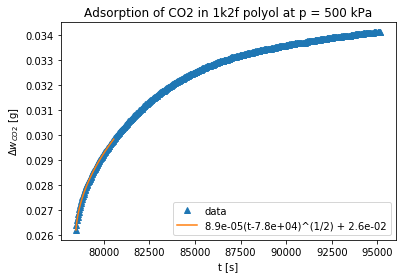

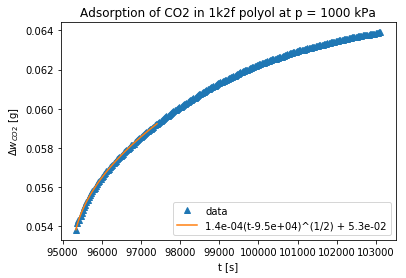

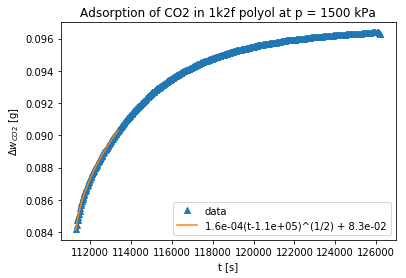

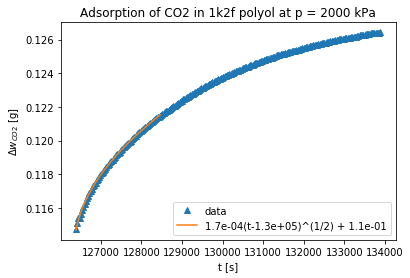

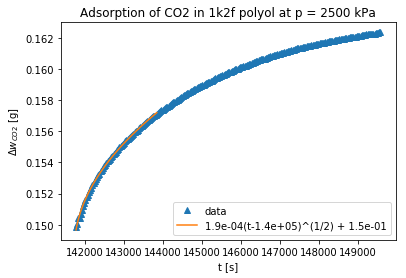

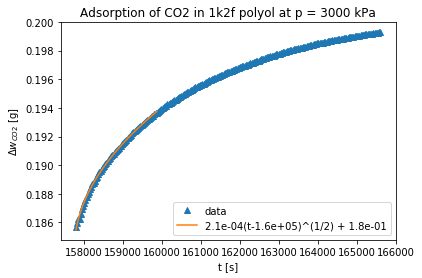

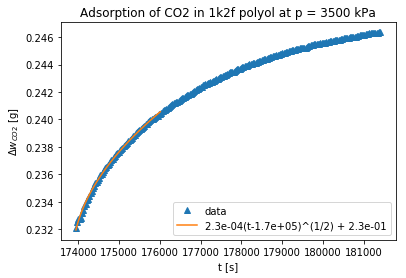

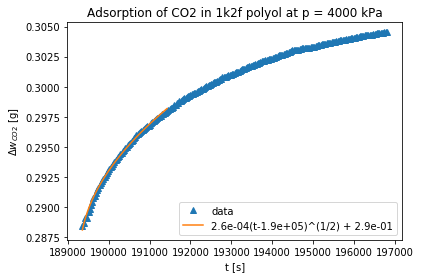

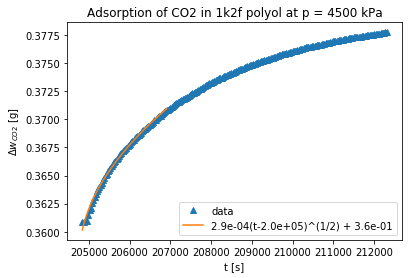

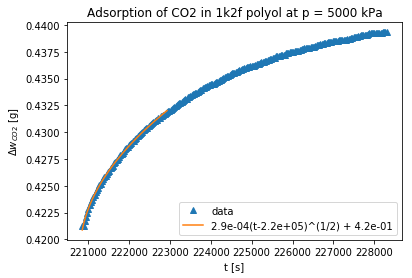

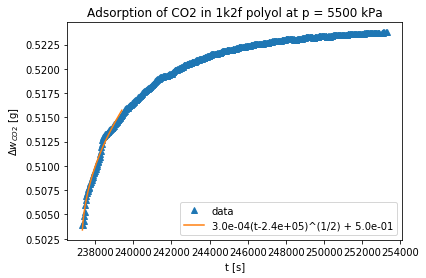

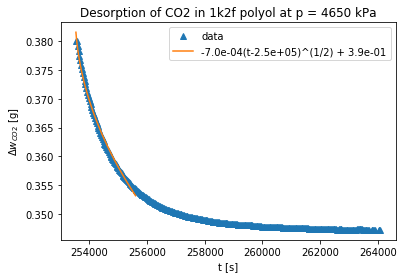

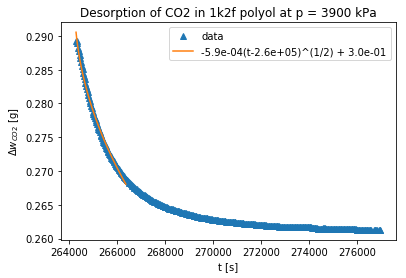

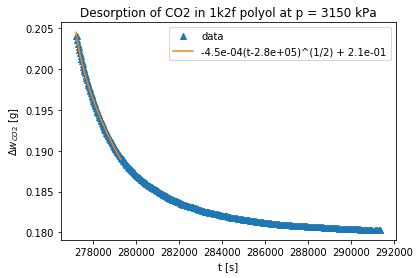

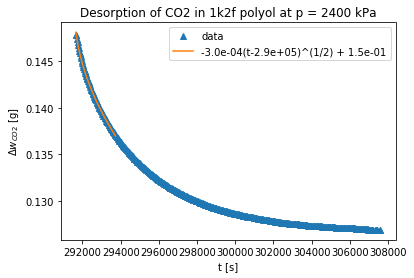

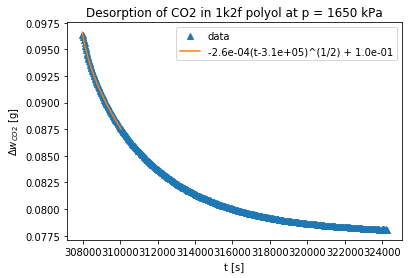

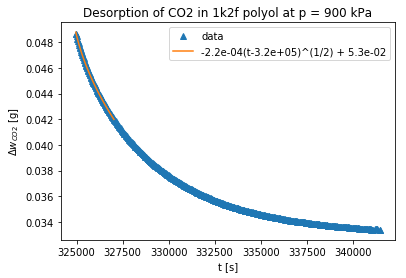

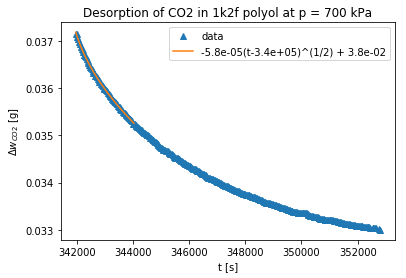

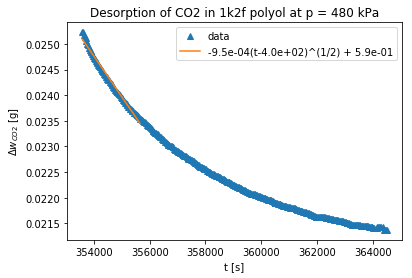

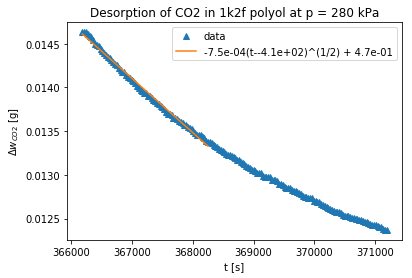

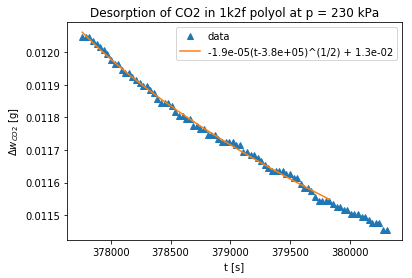

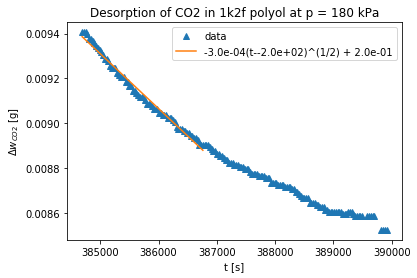

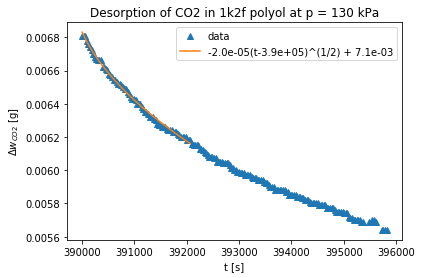

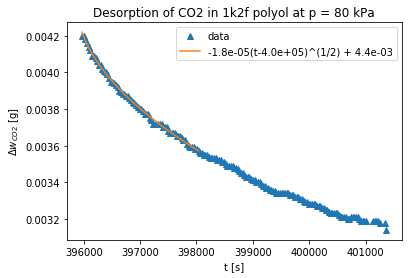

In [19]:
# raise max number of function evaluations for fitting
maxfev = 10000
# number of data points to use for fitting to square root (beginning of curve)
n_pts_sqrt = 70
# number of data points to use for fitting to exponential (end of curve)
n_pts_exp = 50

# initalize marker for pressure bounds
last_bound = 0
# initialize array to store diffusivity values
D_sqrt_arr = np.zeros([len(p_set_arr)])
# Loop through each pressure set point
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    
    # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
    w_gas_act, t_mp1, df_meas, last_bound, is_adsorbing = dataproc.compute_gas_mass(i, p_arr, p_set_arr, df_meas, bp_arr, br_arr, t_grav, 
                     p_thresh_frac, last_bound, v_ref_he)
    
    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
      
    # fit initial data points to a square root curve per eqn 10.165 in Crank (1956) "The Mathematics of Diffusion"
    popt, pcov = curve_fit(dataproc.square_root_3param, t_mp1[:n_pts_sqrt], w_gas_act[:n_pts_sqrt], maxfev=maxfev)
    a = popt[0]
    b = popt[1]
    t0_fit = popt[2]
    # generate data points for t^(1/2) fit
    t_fit = np.linspace(t_mp1[0], t_mp1[n_pts_sqrt-1], 100)
    w_fit = dataproc.square_root_3param(t_fit, a, b, t0_fit)
    # plot the result to examine the fit
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(t_mp1, w_gas_act, '^', label='data')
    ax.plot(t_fit, w_fit, '-', label='{a:.1e}(t-{t0:.1e})^(1/2) + {b:.1e}'.format(a=a, b=b, t0=t0_fit))
    ax.set_xlabel('t [s]')
    ax.set_ylabel(r'$\Delta w_{CO2}$ [g]')
    if is_adsorbing:
        stage = 'Adsorption'
    else:
        stage = 'Desorption'
    ax.set_title(stage + ' of CO2 in 1k2f polyol at p = %d kPa' % p_set)
    plt.legend(loc='best')

    # the initial time of sorption is defined as the point where the pressure began changing after the previous sorption test
    t0 = t_grav[last_bound]
    # compute mean diffusion coefficient with the squareroot method by fitting and exponential curve to get the equilibrium mass
    D_sqrt = dataproc.compute_D_sqrt(i, a, t_mp1, w_gas_act, n_pts_exp, maxfev, diam_cruc, df_meas, t0, t0_fit)
    print('D_sqrt = %.2e cm^2/s.' % D_sqrt)
    # store result
    D_sqrt_arr[i] = D_sqrt
    

#     # try a 1-parameter fit...always fails so far
#     try:
#         # really should use the beginning of the pressure change as point of t0 (indicated by the 'last_bound')
#         t0 = t_grav[last_bound]
#         # shift time and mass
#         t_rel = t_mp1 - t0
#         w_gas_act_0 = dataproc.square_root_3param(t0, a, b, t0_fit)
#         w_rel = w_gas_act - w_gas_act_0
#         # refit the shifted data
#         popt, pcov = curve_fit(dataproc.square_root_1param, t_rel, w_rel, maxfev=maxfev, p0=0.0001)
#         a1 = popt[0]
#         # generate t^(1/2) fit
#         t_fit1 = np.linspace(0, t_rel[-1], 100)
#         w_fit1 = dataproc.square_root_growth(t_fit1, a1)
#         # plot the result on a loglog plot (?)
#         fig = plt.figure()
#         ax = fig.add_subplot(111)
#         ax.plot(t_rel, w_rel, '^', label='data')
#         ax.plot(t_fit1, w_fit1, '-', label='%.1e t^(1/2)' % a1)
#         ax.set_xlabel('t [s]')
#         ax.set_ylabel(r'$\Delta w_{CO2}$ [g]')
#         if is_adsorbing:
#             stage = 'Adsorption'
#         else:
#             stage = 'Desorption'
#         ax.set_title(stage + ' of CO2 in 1k2f polyol at p = %d kPa - 1 param fit' % p_set)
#         plt.legend(loc='best')
#     except:
#         print('1 param fit failed.')

Having computed the mean diffusivities, we will save them.

In [20]:
# record diffusivity calculated using the t^(1/2) (squareroot) fit in the data frame [cm^2/s]
df_meas['mean diffusivity (sqrt) [cm^2/s]'] = D_sqrt_arr

# save results
df_meas.to_csv(save_file_path)

#### Model 2: Exponential Fit (based on equation 10.168 in section 10.6.8 of Crank, 1956)

In the later stages of diffusion, Crank demonstrates that the mass of a sample in an atmosphere of diffusing gas obeys the following equation (equation 10.168 in *The Mathematics of Diffusion*, 1956),

\begin{align*}
\frac{\mathrm{d}}{\mathrm{d}t}\left[\log(M_t - M_{\infty})\right] &= - \frac{D \pi^2}{l^2} \\
\end{align*}

At late enough times, the concentration is close enough to the equilibrium value that the affect of the changing concentration in the system on the diffusion coefficient $D$ is negligible. Therefore, in this model, we assume that $D$ is constant and corresponds to the diffusion coefficient at the equilibrium concentration.

As above, to map this system to the present system where the sample is only exposed to gas on one surface and has a no-flux condition on the other, we replace $l$ with $2 h_{samp}$. We can then integrate the above equation to arrive at the following functional form for the mass of the sample,

\begin{align*}
M_t &= M_{\infty} - (M_{\infty} - M_0) \exp \left[-\frac{D \pi^2}{4 h_{samp}^2} t\right]\\
\end{align*}

where $M_0$ is the mass of the sample at the beginning of the exponential behavior (which we define as $t=0$).

As noted before, $M_t = W_{gas}^{act} + W_{poly}$, and since $W_{poly}$ is constant, it can be "absorbed" in the constant $M_{\infty}$ (so the constant term would represent the equilibrium mass of adsorbed gas rather than of the total sample mass). We can then perform a fit of the mass of adsorbed gas to the following functional form,

\begin{align*}
W_{gas}^{act} &= A \exp \left[B t\right] + C \\
\end{align*}

where $A$, $B$, and $C$ are fitting parameters. Then $C$ is the equilibrium mass of adsorbed gas $W_{gas,\infty}^{act}$ and $B$ can be related to the diffusion constant $D$ by the following equation,

\begin{align*}
D &= -\frac{4 h_{samp}^2}{\pi^2} B\\
\end{align*}

Pressure = 0 kPa.
Pressure = 500 kPa.
D_exp = 6.68e-06 cm^2/s.
Pressure = 1000 kPa.
D_exp = 6.22e-06 cm^2/s.
Pressure = 1500 kPa.
D_exp = 9.09e-06 cm^2/s.
Pressure = 2000 kPa.
D_exp = 8.52e-06 cm^2/s.
Pressure = 2500 kPa.
D_exp = 7.15e-06 cm^2/s.
Pressure = 3000 kPa.
D_exp = 9.26e-06 cm^2/s.
Pressure = 3500 kPa.
D_exp = 1.03e-05 cm^2/s.
Pressure = 4000 kPa.
D_exp = 5.14e-06 cm^2/s.
Pressure = 4500 kPa.
D_exp = 2.19e-05 cm^2/s.
Pressure = 5000 kPa.
D_exp = 2.06e-05 cm^2/s.
Pressure = 5500 kPa.
D_exp = 2.96e-05 cm^2/s.
Pressure = 4650 kPa.
D_exp = 7.22e-05 cm^2/s.
Pressure = 3900 kPa.


C:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


D_exp = 9.33e-02 cm^2/s.
Pressure = 3150 kPa.
D_exp = 1.68e-05 cm^2/s.
Pressure = 2400 kPa.
D_exp = 7.51e-06 cm^2/s.
Pressure = 1650 kPa.
D_exp = 7.16e-06 cm^2/s.
Pressure = 900 kPa.
D_exp = 7.83e-06 cm^2/s.
Pressure = 700 kPa.
D_exp = 8.21e-06 cm^2/s.
Pressure = 480 kPa.
D_exp = 7.12e-06 cm^2/s.
Pressure = 280 kPa.
D_exp = 5.83e-06 cm^2/s.
Pressure = 230 kPa.
D_exp = 6.10e-06 cm^2/s.
Pressure = 180 kPa.
D_exp = 7.49e-06 cm^2/s.
Pressure = 130 kPa.
D_exp = 2.63e-06 cm^2/s.

C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



Pressure = 80 kPa.
D_exp = 8.76e-06 cm^2/s.


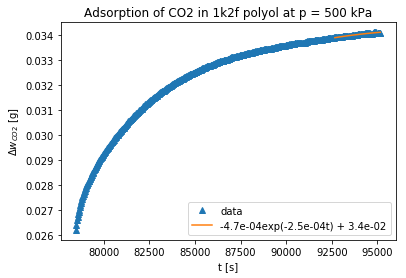

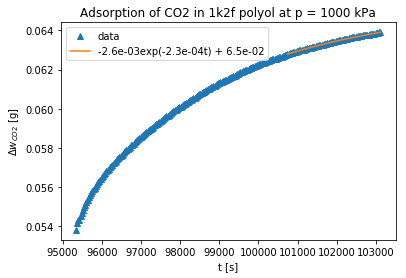

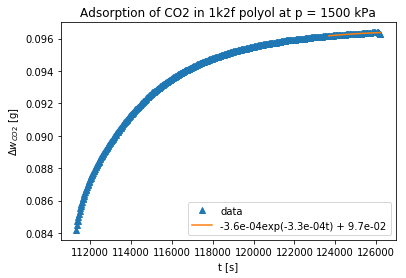

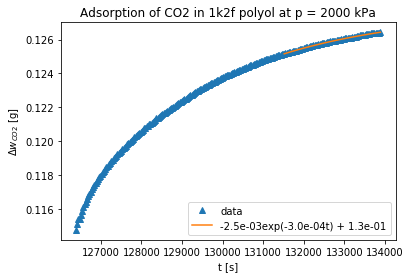

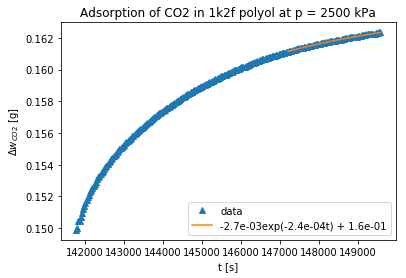

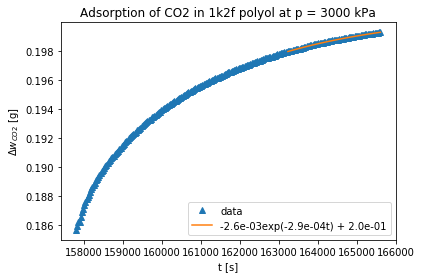

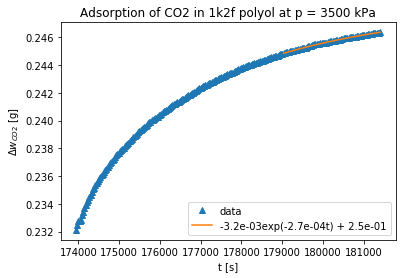

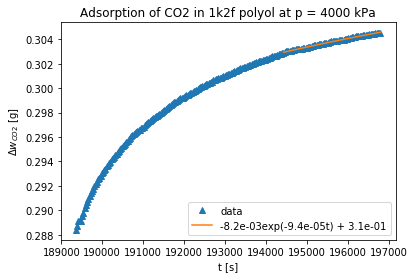

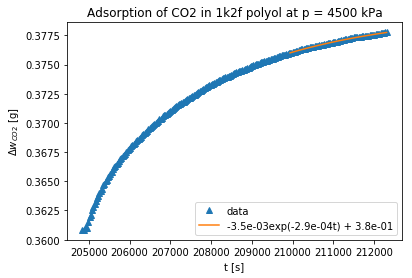

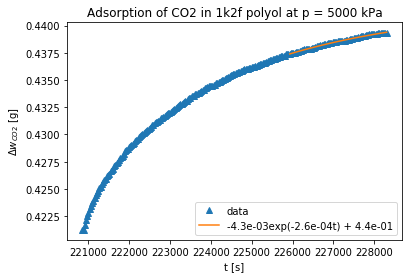

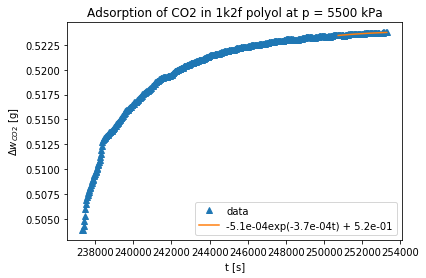

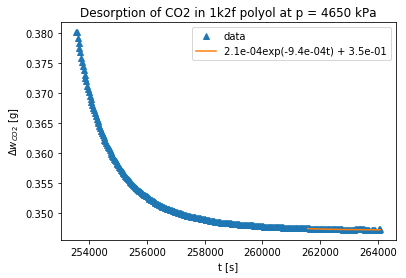

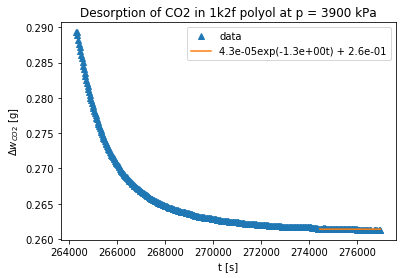

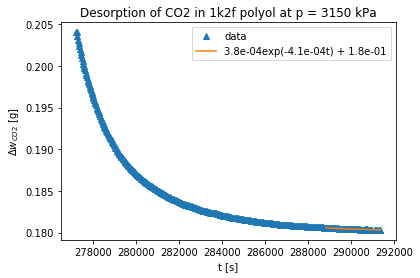

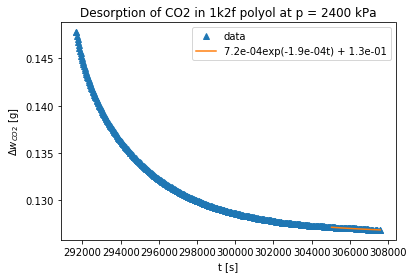

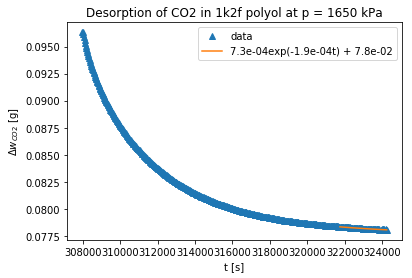

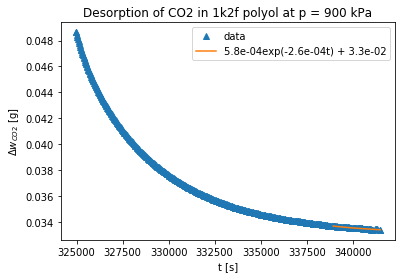

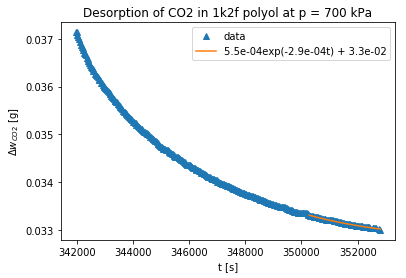

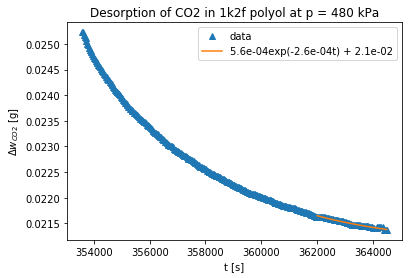

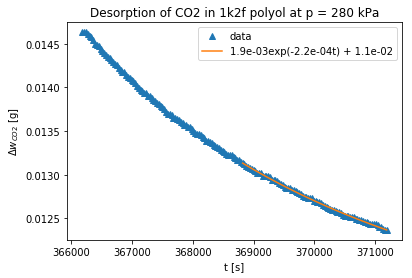

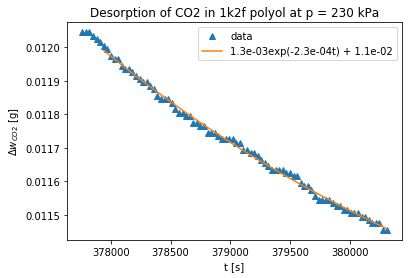

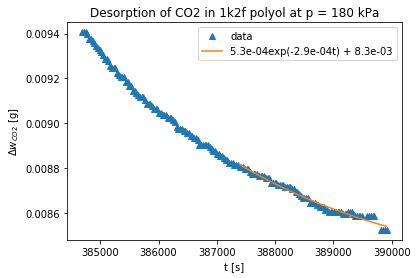

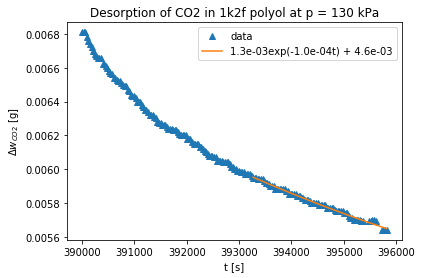

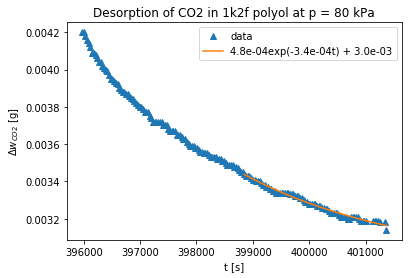

In [32]:
# initalize marker for pressure bounds
last_bound = 0
# set number of points for exponential fit
n_pts_exp = 80
# initialize array to store diffusivity values
D_exp_arr = np.zeros([len(p_set_arr)])
# Loop through each pressure set point
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    
    # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
    w_gas_act, t_mp1, df_meas, last_bound, is_adsorbing = dataproc.compute_gas_mass(i, p_arr, p_set_arr, df_meas, bp_arr, br_arr, t_grav, 
                     p_thresh_frac, last_bound, v_ref_he)
    
    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
        
    # fit initial data points to a square root curve per eqn 10.165 in Crank (1956) "The Mathematics of Diffusion"
    popt, pcov = curve_fit(dataproc.exponential_approach, t_mp1[-n_pts_exp:]-t_mp1[-n_pts_exp], w_gas_act[-n_pts_exp:], maxfev=maxfev, 
                           p0=(-0.01, -0.01, 0.1))
    a, b, c = popt
    # generate data points for exponential fit
    t_fit = np.linspace(t_mp1[-n_pts_exp], t_mp1[-1], 100) - t_mp1[-n_pts_exp]
    w_fit = dataproc.exponential_approach(t_fit, a, b, c)
    # plot the result to examine the fit
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(t_mp1, w_gas_act, '^', label='data')
    ax.plot(t_fit + t_mp1[-n_pts_exp], w_fit, '-', label='{a:.1e}exp({b:.1e}t) + {c:.1e}'.format(a=a, b=b, c=c))
    ax.set_xlabel('t [s]')
    ax.set_ylabel(r'$\Delta w_{CO2}$ [g]')
    if is_adsorbing:
        stage = 'Adsorption'
    else:
        stage = 'Desorption'
    ax.set_title(stage + ' of CO2 in 1k2f polyol at p = %d kPa' % p_set)
    plt.legend(loc='best')

    D_exp = dataproc.compute_D_exp(i, diam_cruc, df_meas, b)
    print('D_exp = %.2e cm^2/s.' % D_exp)
    # store result
    D_exp_arr[i] = D_exp

Having computed the mean diffusivities, we will save them.

In [33]:
# record diffusivity calculated using the exponential fit in the data frame [cm^2/s]
df_meas['mean diffusivity (exp) [cm^2/s]'] = D_exp_arr

# save results
df_meas.to_csv(save_file_path)